In [30]:
import os
os.chdir('/home/khalyl/code/KhalylDammas/neo-hazardous-classification')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from neo.params import *

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [38]:
df = pd.read_csv(DATA_LOCAL_PATH)
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [39]:
df.dropna(inplace=True, ignore_index=True)

In [40]:
n_true = len(df.loc[df['is_hazardous'] == True])
data_length = len(df.index)

remove = data_length - int(MAJOR_RATIO * (n_true/(1-MAJOR_RATIO)) + n_true)
df = df.drop(df.loc[df['is_hazardous'] == False].sample(remove, random_state=RANDOM_STATE).index).reset_index(drop=True)

In [41]:
#Separate features and target
X = df[['absolute_magnitude','estimated_diameter_min','relative_velocity','miss_distance']]
y = df['is_hazardous']

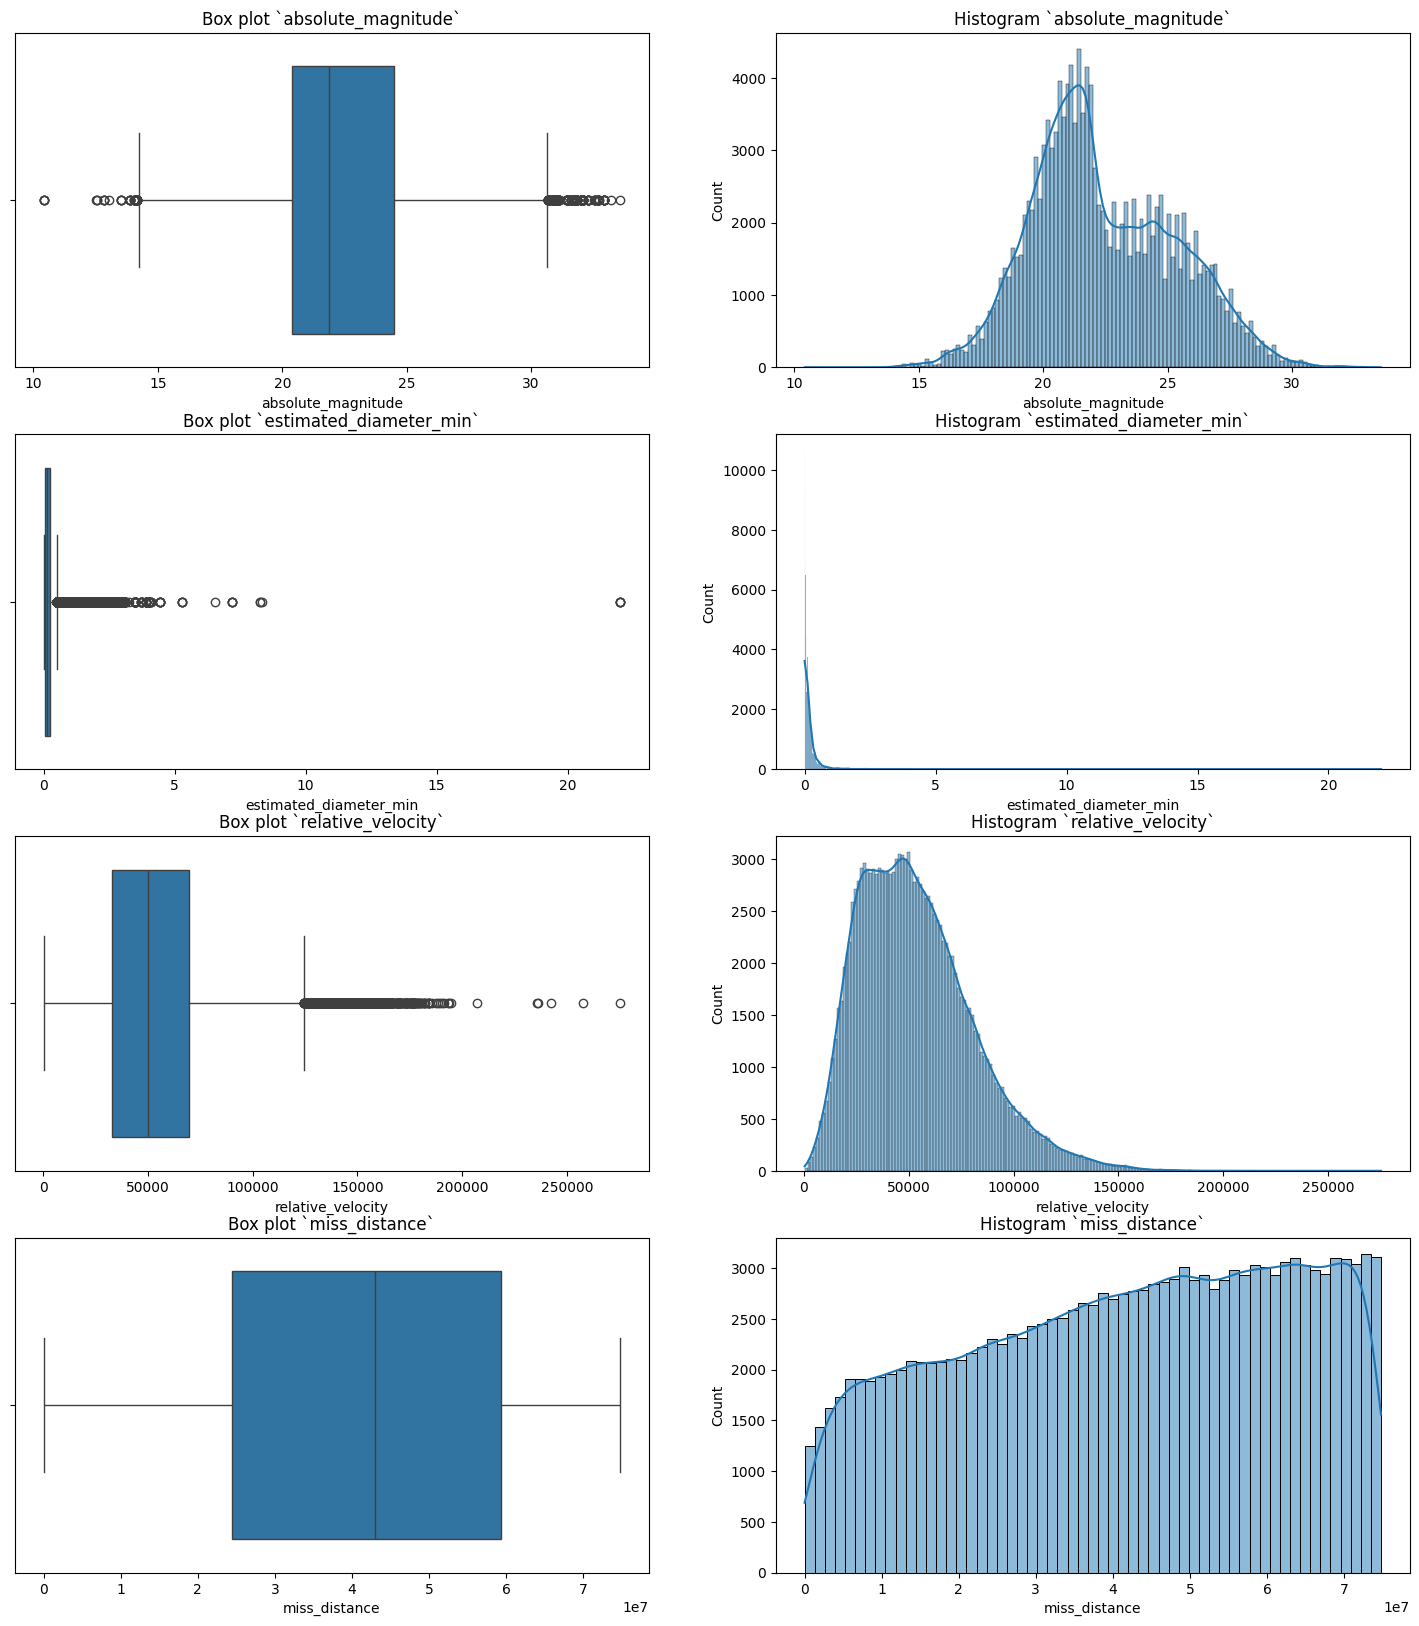

In [42]:
cols = list(X.columns)
n_rows = len(cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(18, 20))

for i in range(n_rows):
    # Box plot
    sns.boxplot(data=X, x=cols[i], ax=axes[i, 0])
    axes[i, 0].set_title(f"Box plot `{cols[i]}`")
    # Hostogram
    sns.histplot(data=X, x=cols[i], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Histogram `{cols[i]}`")


In [43]:
# print the X columns (features)
X.head()

,absolute_magnitude,estimated_diameter_min,relative_velocity,miss_distance
0,18.50,0.530341,109949.757148,5.580105e+07
1,20.63,0.198863,78890.076805,3.039644e+07
2,21.50,0.133216,57853.295346,2.727908e+07
3,19.75,0.298233,46972.486794,6.997593e+07
4,21.70,0.121494,37424.548382,5.657727e+06


In [44]:
X.describe()

,absolute_magnitude,estimated_diameter_min,relative_velocity,miss_distance
count,143873.000000,143873.000000,143873.000000,1.438730e+05
mean,22.410336,0.183709,53647.190088,4.138865e+07
std,2.861053,0.295257,27174.570956,2.080573e+07
min,10.410000,0.000511,288.603247,8.098256e+03
25%,20.380000,0.033462,32911.908798,2.446826e+07
50%,21.870000,0.112345,50009.261178,4.304321e+07
75%,24.500000,0.223128,69607.725188,5.930445e+07
max,33.580000,22.006703,275303.183496,7.479802e+07


### piplene multiple models

In [45]:
# Set up the Pipeline with MinMaxScaler
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression())  # Default classifier, will be replaced in GridSearchCV
])

In [54]:
# Define hyperparameter grids for each model
param_grid = [
    # Logistic Regression parameters
    {'classifier': [LogisticRegression()],
     'classifier__C': [0.01, 0.1, 1, 10, 100]},

    # SVM (Linear Kernel) parameters
    {'classifier': [SVC()],
     'classifier__kernel': ['linear', 'rbf'],
     'classifier__C': [0.01, 0.1, 1, 10, 100],
     'classifier__gamma': ['scale', 0.001, 0.01, 0.1, 1]},

    # K-Nearest Neighbors parameters
    {'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': [3, 5, 7, 9, 11]}
]

In [55]:
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=5)

In [56]:
# Fit the grid search on the training data
grid_search.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 3/5] END classifier=LogisticRegression(), classifier__C=0.01;, score=0.285 total time=   0.3s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=0.01;, score=0.325 total time=   0.3s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=1;, score=0.518 total time=   0.3s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=0.1;, score=0.390 total time=   0.3s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=0.1;, score=0.431 total time=   0.4s
[CV 1/5] END classifier=LogisticRegression(), classifier__C=0.1;, score=0.450 total time=   0.4s
[CV 2/5] END classifier=LogisticRegression(), classifier__C=1;, score=0.497 total time=   0.4s
[CV 4/5] END classifier=LogisticRegression(), classifier__C=0.01;, score=0.261 total time=   0.4s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=1;, score=0.481 total time=   0.4s
[CV 3/5] END classifier=LogisticRegression(), classifier__C=0.1;, sc

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.01, 0.1, 1, 10, 100]},
                         {'classifier': [SVC()],
                          'classifier__C': [0.01, 0.1, 1, 10, 100],
                          'classifier__gamma': ['scale', 0.001, 0.01, 0.1, 1],
                          'classifier__kernel': ['linear', 'rbf']},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [3, 5, 7, 9, 11]}],
             scoring='recall', verbose=5)

In [57]:
# Print the best parameters and the best accuracy score
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'classifier': SVC(), 'classifier__C': 100, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


In [58]:
grid_search.best_score_

np.float64(0.7581648596721399)

In [ ]:
# Evaluate the best model on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best model accuracy on the test set: {accuracy:.4f}')

### another way for piplene multiple models

In [ ]:
pipe = Pipeline([('scaled' , MinMaxScaler()),
                 ('LR' ,LogisticRegression())])
pipe.fit(X_train ,y_train)
print(accuracy_score(y_test, pipe.predict(X_test)))

In [ ]:
pipelines = []
pipelines.append(('scaledLR' , (Pipeline([('scaled' , MinMaxScaler()),('LR' ,LogisticRegression())]))))
pipelines.append(('scaledKNN' , (Pipeline([('scaled' , MinMaxScaler()),('KNN' ,KNeighborsClassifier())]))))
pipelines.append(('scaledDT' , (Pipeline([('scaled' , MinMaxScaler()),('DT' ,DecisionTreeClassifier())]))))
pipelines.append(('scaledSVC' , (Pipeline([('scaled' , MinMaxScaler()),('SVC' ,SVC())]))))
pipelines.append(('scaledMNB' , (Pipeline([('scaled' , MinMaxScaler()),('MNB' ,GaussianNB())]))))

model_name = []
results = []
for pipe ,model in pipelines:
    kfold = KFold(n_splits=10, random_state=42)
    crossv_results = cross_val_score(model , X_train ,y_train ,cv =kfold , scoring='accuracy')
    results.append(crossv_results)
    model_name.append(pipe)
    msg = "%s: %f (%f)" % (model_name, crossv_results.mean(), crossv_results.std())
    print(msg)

In [ ]:
# Compare different Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(model_name)
plt.show()